# Description

**Diabetes RDD data-driven exclusion case study**

Notebook for cleaning features for data-driven exclusion on diabetes Optum analysis for CLeaR 2022.

Because the data cannot be publicly shared, this notebook *will not* run, and is only for informational purposes.

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle

In [2]:
pd.options.display.float_format = '{:.3f}'.format

# Load data

## A1C and diabetes diagnosis

In [3]:
data_path = "/project/liu_optum_causal_inference/data/tony_scratch/diabetes_archive/"
proj_path = "../"

In [4]:
diabetes_df = pd.read_pickle(os.path.join(data_path, "a1c_sorted_clean.df"))

In [5]:
diab_tups = pickle.load(open(os.path.join(data_path, "dm_dm_bsub.tup"), "rb"))
prior_diab_dict = {tup[0]: tup[1] for tup in diab_tups if tup is not None}
post_diab_dict = {tup[0]: tup[2] for tup in diab_tups if tup is not None}
diabetes_df['prior_dm'] = diabetes_df['patid'].map(prior_diab_dict)
diabetes_df['dm_within_yr'] = diabetes_df['patid'].map(post_diab_dict)

In [6]:
diab_30_tups = pickle.load(open(os.path.join(data_path, "dm_dm_30.tup"), "rb"))
prior_diab_30_dict = {tup[0]: tup[1] for tup in diab_30_tups if tup is not None}
post_diab_30_dict = {tup[0]: tup[2] for tup in diab_30_tups if tup is not None}
diabetes_df['prior_dm_mnth'] = diabetes_df['patid'].map(prior_diab_30_dict)
diabetes_df['dm_within_mnth'] = diabetes_df['patid'].map(post_diab_30_dict)

In [7]:
diabetes_df.shape

(4841582, 23)

In [8]:
diabetes_df['patid'].unique().shape

(4841582,)

In [10]:
diabetes_df['patid'] = diabetes_df['patid'].astype(int).astype(str)

### Process outcome: follow-up A1C

In [11]:
fu_a1cs = pickle.load(open(os.path.join(proj_path, "data", "filter_fu_a1c_list.pkl"), "rb"))

In [12]:
fu_a1c_dict = {val[0][0]: val[0][2] for val in fu_a1cs}
mean_a1c_dict = {val[0][0]: val[0][3] for val in fu_a1cs}

In [13]:
diabetes_df['fu_first_a1c'] = diabetes_df['patid'].map(fu_a1c_dict)
diabetes_df['fu_mean_a1c'] = diabetes_df['patid'].map(mean_a1c_dict)

In [14]:
diabetes_df['fu_first_a1c'].describe()

count    1190973.000
mean        -270.326
std        16643.665
min     -1000000.000
25%            5.800
50%            6.200
75%            7.100
max          404.000
Name: fu_first_a1c, dtype: float64

In [15]:
diabetes_df['fu_mean_a1c'].describe()

count    1190973.000
mean        -212.537
std        12858.917
min     -1000000.000
25%            5.800
50%            6.200
75%            7.100
max      5000002.800
Name: fu_mean_a1c, dtype: float64

In [16]:
# our outcome is follow-up a1c, which requires the existence of it
diabetes_df = diabetes_df[~diabetes_df['fu_first_a1c'].isna()]

## Create diabetes_df and plot treatment

In [24]:
# include patients with no prior diagnosis of DM
diabetes_df = diabetes_df.loc[(diabetes_df['prior_dm'] == 0)]

In [25]:
# include patients with no prior presciption of DM medicine
diabetes_df = diabetes_df.loc[(diabetes_df['prior_rx'] == 0) | (diabetes_df['prior_met'] == 0)]

In [26]:
# include adults only, and filter out corrupted age entries
diabetes_df = diabetes_df.loc[(diabetes_df['age'] >= 18) & (diabetes_df['age'] < 100)]

In [27]:
# drop missing and unknown age/gender
diabetes_df = diabetes_df.dropna(subset=["age", "gdr_cd"], axis='rows')
diabetes_df = diabetes_df[diabetes_df['gdr_cd'] != 'U']

In [28]:
diabetes_df['rounded_a1c'] = diabetes_df['norm_rslt'].round(1)

In [29]:
# Apply filter on normalized A1C results to remove corrupted entries
diabetes_df = diabetes_df[(diabetes_df['norm_rslt'] < 21) & (diabetes_df['norm_rslt'] > 4)]
diabetes_df = diabetes_df[(diabetes_df['fu_first_a1c'] < 21) & (diabetes_df['fu_first_a1c'] > 4)]

In [30]:
diabetes_df.shape

(284996, 28)

## Member status

In [31]:
mbr_df = pd.read_pickle(os.path.join(proj_path, "data", "mbr_thin.df"))
mbr_df['patid'] = mbr_df['patid'].astype(int).astype(str)

In [32]:
diabetes_df = diabetes_df.merge(mbr_df[['patid', 'eligeff', 'eligend', 'bus']], on=['patid', 'eligeff', 'eligend'], how='left')

In [33]:
del mbr_df

In [34]:
diabetes_df.shape

(284996, 29)

## SES

In [35]:
ses_df = pd.read_pickle(os.path.join(data_path, "ses.df"))

In [36]:
ses_df['patid'] = ses_df['patid'].astype(int).astype(str)

In [37]:
ses_df.columns

Index(['patid', 'd_education_level_code', 'd_fed_poverty_status_code',
       'd_home_ownership_code', 'd_household_income_range_code',
       'd_networth_range_code', 'd_occupation_type_code', 'd_race_code',
       'num_adults', 'num_child', 'extract_ym', 'version'],
      dtype='object')

- isa13040: self-reported hypertension
- isa9009: physical activity
- HRA looks a bit too sparse to be useable

# Build dataframe for data-driven exclusion

In [38]:
rdd_dm = diabetes_df[['patid', 'norm_rslt', 'fst_dt', 'gdr_cd', 
                      'dm_within_yr', 'dm_within_mnth',
                      'prior_dm', 'prior_rx', 'age', 
                      'fu_first_a1c',
                      'bus']]

In [39]:
rdd_dm = rdd_dm.merge(ses_df, 
                      on='patid', how='left')
rdd_dm = rdd_dm.reset_index(drop=True)

In [40]:
rdd_dm.describe()

,norm_rslt,dm_within_yr,dm_within_mnth,prior_met,prescribe_met,prescribe_met_first,prior_dm,prior_rx,age,fu_first_a1c,fu_mean_a1c,num_adults,num_child
count,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,284996.000,265821.000,265821.000
mean,6.904,0.543,0.271,0.000,0.132,0.122,0.000,0.086,58.257,6.715,-95.652,1.879,0.139
std,1.685,0.498,0.444,0.000,0.338,0.327,0.000,0.281,13.178,1.395,6113.618,1.210,0.503
min,4.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18.000,4.100,-499997.350,1.000,0.000
25%,5.900,0.000,0.000,0.000,0.000,0.000,0.000,0.000,49.000,5.900,5.900,1.000,0.000
50%,6.400,1.000,0.000,0.000,0.000,0.000,0.000,0.000,59.000,6.300,6.300,1.000,0.000
75%,7.200,1.000,1.000,0.000,0.000,0.000,0.000,0.000,67.000,7.000,7.033,2.000,0.000
max,20.500,1.000,1.000,0.000,1.000,1.000,0.000,1.000,88.000,20.800,163.800,14.000,10.000


In [41]:
rdd_dm = rdd_dm.reset_index(drop=True)

In [42]:
rdd_dm.shape

(284996, 26)

In [43]:
rdd_dm[['norm_rslt', 'age', 'fu_first_a1c']].describe()

,norm_rslt,age,fu_first_a1c
count,284996.000,284996.000,284996.000
mean,6.904,58.257,6.715
std,1.685,13.178,1.395
min,4.100,18.000,4.100
25%,5.900,49.000,5.900
50%,6.400,59.000,6.300
75%,7.200,67.000,7.000
max,20.500,88.000,20.800


## Plot treatment

[ 0  1  2  3  4  5  6  7  8  9 10]


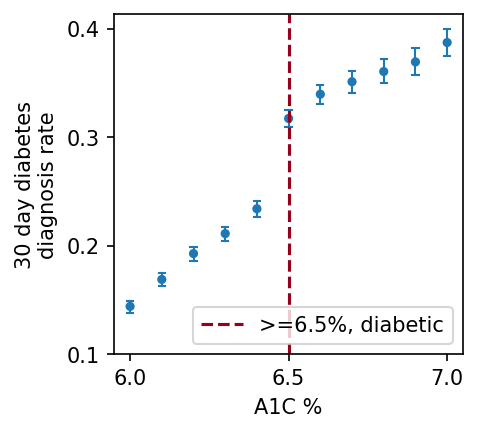

In [148]:
fig, ax = plt.subplots(figsize=(3,3),dpi=150)
treat_y = 'dm_within_mnth'
rdd_dm['rounded_a1c'] = rdd_dm['norm_rslt'].round(1)

p_red = '#95001A'


sns.pointplot(x='rounded_a1c', y=treat_y, 
              data=rdd_dm[(rdd_dm['rounded_a1c'] < 7.1) 
                          & (rdd_dm['rounded_a1c'] >= 6.0) 
                         ], 
              join=False, 
              ax=ax,
              errwidth=1,
              capsize=0.2,
              scale=0.5);
#ax.set_xlim(6, 7)
xticks = ax.get_xticks()
print(xticks)
ax.set_xticks([idx for idx in xticks if idx % 5 == 0 ])

# 5 because pointplot indexes by int
ax.axvline(x=5, color=p_red, label='>=6.5%, diabetic', ls='--')

ax.set_xlabel("A1C %")
ax.set_ylabel("30 day diabetes\ndiagnosis rate");
ax.set_yticks(np.round(np.arange(0.1, 0.45, 0.1), 1))
fig.set_facecolor("white");
ax.legend();

plt.savefig("dm_rate.png", bbox_inches='tight', dpi=300)

# Establish bandwidth of analysis

In [72]:
# workaround to drop into R since both rdd.py and rpy2 are broken on the cluster
rdd_dm[['norm_rslt', 'dm_within_mnth', 'fu_first_a1c']].to_csv(os.path.join(proj_path, "data", "dm_run_outcome.csv"),
                                         index=False)

- R commands to extract bandwidth

```
> library(rdd)
> rdd_dm = read.csv("data/dm_run_outcome.csv")
> X = rdd_dm$norm_rslt
> Y = rdd_dm$fu_first_a1c
> IKbandwidth(X, Y, cutpoint=6.5)
[1] 0.3681729
```

In [115]:
bandwidth = 0.3681729

result_dir = "results/final_cforest_dm_fu_0.36"

## Treatment and outcome of interest

In [116]:
treatment_col = "dm_within_mnth"

## Create in/out bandwidth indicator

In [117]:
cutpoint = 6.5

In [118]:
# subtract a little more off the lower bound to ensure the same number of A1C readings below and above the cutoff
rdd_dm['in_bw'] = (rdd_dm['norm_rslt'] >= cutpoint - bandwidth - 0.1) & (rdd_dm['norm_rslt'] <= cutpoint + bandwidth)

In [119]:
unique_vals = rdd_dm[rdd_dm['in_bw']]['rounded_a1c'].unique()
assert np.sum(unique_vals < 6.5) == np.sum(unique_vals >= 6.5)

In [120]:
out_bw_df = rdd_dm[~rdd_dm['in_bw']].copy()
in_bw_df = rdd_dm[rdd_dm['in_bw']].copy()

assert (out_bw_df.shape[0] + in_bw_df.shape[0]) == rdd_dm.shape[0], "split was not a clean partition"

## Dump full diabetes dataframe

In [121]:
rdd_dm.to_pickle(os.path.join(proj_path, result_dir, "rdd_dm.df"))

## Density test

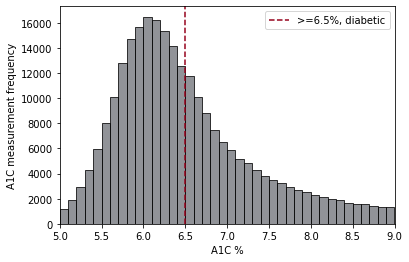

In [158]:
penn_red = '#95001A'
penn_blue = '#045EA7'
penn_light_blue = '#82afd3'
penn_gray = '#6C6F76'

sel_df = rdd_dm[(rdd_dm['rounded_a1c'] >= 5) & (rdd_dm['rounded_a1c'] <= 9)]
sns.histplot(sel_df['rounded_a1c'], kde=False, bins=np.arange(5.0, 9.05, 0.1), color=penn_gray)
plt.axvline(x=6.5,label='>=6.5%, diabetic', ls='--', color=penn_red)
plt.xlim(5, 9)
#plt.ylim(0,25000)
plt.ylabel("A1C measurement frequency")
plt.xlabel("A1C %")
#plt.title("A1C frequency, post 2010")
plt.legend()
plt.savefig("a1c_density.png", dpi=300, bbox_inches='tight')

# Create columns for compliance estimation

In [122]:
# TODO may want to drop some of these for redundancy/relevancy
ses_cols = [
    'gdr_cd',
    'age',
    'd_education_level_code',
    'd_fed_poverty_status_code',
    'd_home_ownership_code',
    'd_household_income_range_code',
    'd_networth_range_code',
    'd_race_code', 
    'bus',
]

In [123]:
comp_est_df = rdd_dm#.copy()
comp_est_df = comp_est_df.reset_index(drop=True)

comp_est_df['Z'] = (comp_est_df['norm_rslt'] >= cutpoint).astype(int)
comp_est_df['T'] = comp_est_df[treatment_col]
comp_est_df = comp_est_df[ses_cols \
                          + ['Z', 'T', 'patid', 'in_bw', 'fst_dt']]

In [124]:
# only 19 patients with no age, possible corrupted entries to discard
comp_est_df = comp_est_df.dropna(subset=["age", "gdr_cd"], axis='rows')

## Featurized categorical variables

Source: CDM Data Dictionary 7.0 SES

d_education_level_code:
- A	Less than 12th Grade
- B	High School Diploma
- C	Less than Bachelor Degree
- D	Bachelor Degree Plus
- U	Unknown

d_fed_poverty_status_code:

- A	Above 400% FPL
- B	Below 400% FPL
- U	Unknown/Missing

d_home_ownership_code:
- 1	Probable Homeowner
- 0	Unknown

d_household_income:
- 0	Unknown
- 1	<\$40K
- 2	\$40K-\$49K
- 3	\$50K-\$59K
- 4	\$60K-\$74K
- 5	\$75K-\$99K
- 6	\$100K+

d_networth_range:
- 5	\$500K+
- 4	\$250K-\$499K
- 3	\$150K-\$249K
- 2	\$25K-\$149K
- 1	<\$25K
- 0	Unknown

d_occupation_type_code:
- 1	Manager/Owner/Professional
- 2	White Collar/Health/Civil Service/Military
- 3	Blue Collar
- 4	Homemaker/Retired
- U	Missing/Unknown

d_race_code:
- A	Asian
- B	Black
- H	Hispanic
- U	Unknown
- W	White

In [125]:
# unknowns are 0 and U
comp_est_df = comp_est_df.replace("U", np.nan)
comp_est_df = comp_est_df.replace("0", np.nan)

In [126]:
comp_est_df.isna().sum()

gdr_cd                                0
age                                   0
d_education_level_code            20072
d_fed_poverty_status_code         67779
d_home_ownership_code             77660
d_household_income_range_code     67779
d_networth_range_code             42581
d_occupation_type_code           235042
d_race_code                       28801
bus                                   0
Z                                     0
T                                     0
patid                                 0
in_bw                                 0
fst_dt                                0
dtype: int64

In [127]:
# non-ordered categoricals
unordered_cats = ['gdr_cd', 'd_occupation_type_code', 'd_race_code', 'd_home_ownership_code', 'd_fed_poverty_status_code', 
                  'bus'
                 ]
comp_est_df = pd.get_dummies(comp_est_df, columns=unordered_cats, dummy_na=True)

In [128]:
# ordered categoricals
edu_dict = {char: num for char, num in zip('ABCD', range(1,5))}
comp_est_df['d_education_level_code'] = comp_est_df['d_education_level_code'].map(edu_dict)

# use capital "Int64" to allow for nullable integer types: 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html#integer-na
ordered_cats = ['d_education_level_code', 'd_networth_range_code', 'd_household_income_range_code']
for cat in ordered_cats:
    comp_est_df[cat] = comp_est_df[cat].astype(float)
    comp_est_df[cat] = comp_est_df[cat].astype("Int64")

In [129]:
# create nan indicator
comp_est_df = pd.concat([comp_est_df, comp_est_df[ordered_cats].isnull().astype(int).add_suffix("_nan")], axis=1)

In [130]:
# fill missing values
display(comp_est_df[ordered_cats].mode())
comp_est_df[ordered_cats] = comp_est_df[ordered_cats].fillna(value=comp_est_df[ordered_cats].mode().iloc[0])

,d_education_level_code,d_networth_range_code,d_household_income_range_code
0,3,4,6


## Continuous variables

In [131]:
comp_est_df['days_from_2001'] = (comp_est_df['fst_dt'] - pd.to_datetime('2001-01-01')).dt.days

## Confirm no missing values remain

In [132]:
comp_est_df.isna().sum()

age                                  0
d_education_level_code               0
d_household_income_range_code        0
d_networth_range_code                0
Z                                    0
T                                    0
patid                                0
in_bw                                0
fst_dt                               0
gdr_cd_F                             0
gdr_cd_M                             0
gdr_cd_nan                           0
d_occupation_type_code_1             0
d_occupation_type_code_2             0
d_occupation_type_code_3             0
d_occupation_type_code_4             0
d_occupation_type_code_nan           0
d_race_code_A                        0
d_race_code_B                        0
d_race_code_H                        0
d_race_code_W                        0
d_race_code_nan                      0
d_home_ownership_code_1              0
d_home_ownership_code_nan            0
d_fed_poverty_status_code_A          0
d_fed_poverty_status_code

### Correlation sanity checks

In [133]:
comp_est_df = comp_est_df.drop(['bus_nan'], axis='columns', errors='ignore')

In [134]:
#fig, ax = plt.subplots(figsize=(20, 15), dpi=75)
# corr_df = comp_est_df.drop(['patid', 'pred_comply'], axis='columns', errors='ignore').copy()
# sns.clustermap(corr_df.corr(), cmap='coolwarm', center=0, annot=True, figsize=(20,15))

### Drop completely redundant columns

In [135]:
drop_cols = [
    'gdr_cd_M',
    'd_fed_poverty_status_code_nan',
    'd_household_income_range_code_nan', 
    'd_home_ownership_code_nan',
    'd_networth_range_code_nan',
    'self_report_exercise_nan',
    'h_bmi_nan',
    'bus_COM',
    'gdr_cd_nan'
]

comp_est_df = comp_est_df.drop(drop_cols, axis='columns', errors='ignore')

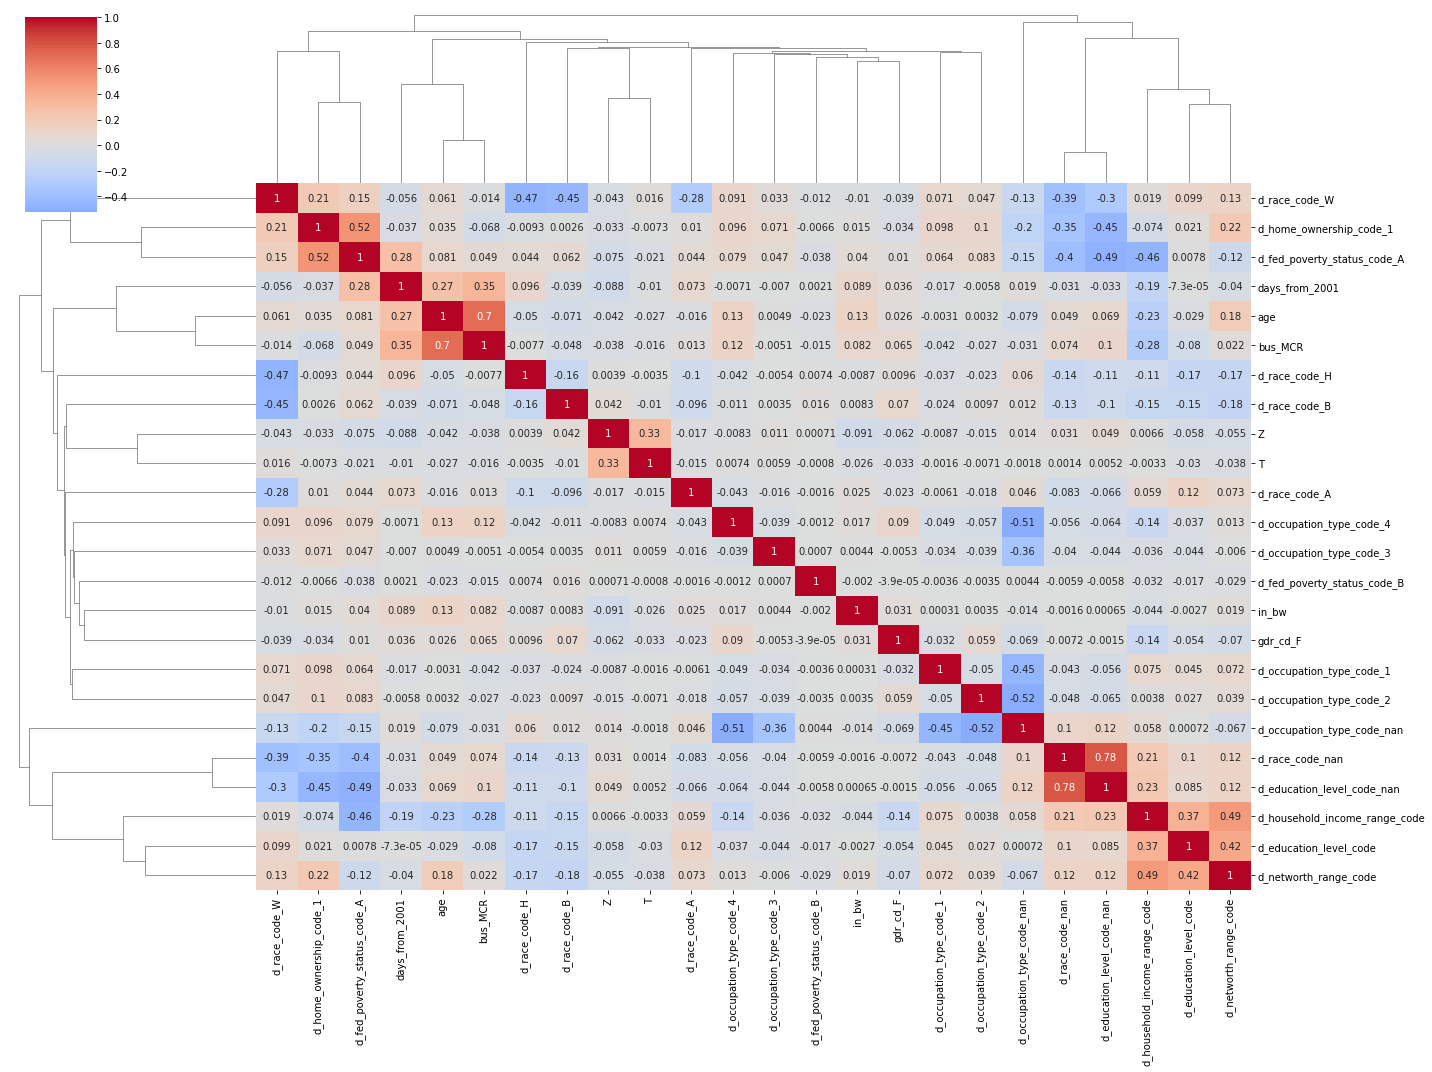

In [136]:
#fig, ax = plt.subplots(figsize=(20, 15), dpi=75)
corr_df = comp_est_df.drop(['patid', 'pred_comply'], axis='columns', errors='ignore').copy()
sns.clustermap(corr_df.corr(), cmap='coolwarm', center=0, annot=True, figsize=(20,15))

# Dump finalized feature dataframe

In [137]:
comp_est_df.columns

Index(['age', 'd_education_level_code', 'd_household_income_range_code',
       'd_networth_range_code', 'Z', 'T', 'patid', 'in_bw', 'fst_dt',
       'gdr_cd_F', 'd_occupation_type_code_1', 'd_occupation_type_code_2',
       'd_occupation_type_code_3', 'd_occupation_type_code_4',
       'd_occupation_type_code_nan', 'd_race_code_A', 'd_race_code_B',
       'd_race_code_H', 'd_race_code_W', 'd_race_code_nan',
       'd_home_ownership_code_1', 'd_fed_poverty_status_code_A',
       'd_fed_poverty_status_code_B', 'bus_MCR', 'd_education_level_code_nan',
       'days_from_2001'],
      dtype='object')

In [138]:
comp_est_df.shape

(284996, 26)

In [139]:
comp_est_df[comp_est_df['in_bw']].shape

(96361, 26)

In [140]:
comp_est_df.to_pickle(os.path.join(proj_path, result_dir, "comp_est.df"))